# PAINS flagging of compounds and Murcko scaffold analysis.
This notebook shows the distirvution of unwanted structures in patent documents. It also shows the distribution of murcko scaffolds in patent docuemnts.

# Import Module

In [1]:
import string
import json
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# Add path constants

In [2]:
DATA_DIR = '../data/raw'
FIGURE_DIR = '../data/figures'
MAPPINGS_DIR = '../data/mappings'

# Load data files

Properties files

In [3]:
properties_dict = json.load(open(f'{MAPPINGS_DIR}/properties.json'))

In [4]:
properties_df = pd.DataFrame(properties_dict)
properties_df = properties_df.T
properties_df.reset_index(inplace=True)
properties_df.rename(columns={'index': 'SMILES'}, inplace=True)
properties_df.head(2)

,SMILES,mw,logp,n_hba,n_hbd,rot_bonds,tpsa,fsp3,n_chiral,n_ring,n_heteroatoms,so_atoms
0,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,217.077264,0.6279,3,2,3,57.61,0.777778,1,1,5,False
1,O=C(O)\C=C/C(=O)O.CCOC(=O)[C@H](CCC1=CC=CC=C1)...,492.210781,1.3164,7,4,11,170.54,0.458333,1,2,11,False


SureChEMBL data

In [5]:
surechembl_df = pd.read_parquet(f'{DATA_DIR}/surechembl_dump.pq')
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


In [6]:
surechembl_df['year'] = surechembl_df['PUBLICATION_DATE'].progress_apply(lambda x: x.split('-')[0])

100%|██████████| 133512452/133512452 [05:04<00:00, 438743.54it/s]


PAINS dump

In [7]:
pain_data = pd.read_csv(f'{MAPPINGS_DIR}/pain_data.csv', sep=';')
pain_data = pain_data[[
    'smiles (Largest component)',  # desalted smiles
    'Total match counts',
    'Rules',
    'Descriptions'
]]
pain_data.head(2)

,smiles (Largest component),Total match counts,Rules,Descriptions
0,O=C(C(=O)C1=CC=CC=C1)C1=CC=CC=C1,1,PAINS filters (family A),imine_one_A(321)
1,CC(C)(\N=N\C(C)(C)C#N)C#N,1,PAINS filters (family A),azo_A(324)


In [8]:
# find percentage of unwanted structures in the dataset
(pain_data['smiles (Largest component)'].nunique() / properties_df[properties_df.mw < 2000]['SMILES'].nunique()) * 100

3.561254189223906

Murcko scaffold dump

In [9]:
murcko_mapping_dict = json.load(open(f'{MAPPINGS_DIR}/murcko_scaffolds.json'))
len(murcko_mapping_dict)

10695979

In [10]:
murcko_wt_dict = json.load(open(f'{MAPPINGS_DIR}/murcko_scaffold_mol_wt.json'))
len(murcko_wt_dict)

5163047

In [11]:
surechembl_df['scaffold'] = surechembl_df['SMILES'].map(murcko_mapping_dict)
surechembl_df['scaffold_wt'] = surechembl_df['scaffold'].map(murcko_wt_dict)
surechembl_df['scaffold'].nunique()

5163052

# Top 10 pain descriptors

In [12]:
pain_data['Descriptions'].nunique()

277

In [13]:
pain_descriptors = pain_data['Descriptions'].value_counts().to_frame()
pain_descriptors['percentage'] = (pain_descriptors.Descriptions / pain_descriptors.Descriptions.sum()) * 100
pain_descriptors.head(10)

,Descriptions,percentage
azo_A(324),71539,18.534908
anil_di_alk_A(478),53902,13.965370
indol_3yl_alk(461),33103,8.576596
catechol_A(92),23500,6.088572
anil_di_alk_C(246),22029,5.707453
quinone_A(370),20697,5.362348
dyes5A(27),15780,4.088411
mannich_A(296),15562,4.031930
imine_one_A(321),14940,3.870777
anil_di_alk_E(186),12726,3.297156


# Visualization

In [14]:
df = surechembl_df.copy()[['scaffold', 'year', 'PATENT_ID']]
df.dropna(inplace=True)
df.to_parquet(f'{MAPPINGS_DIR}/scaffold_mapped_patents.pq')

In [15]:
scaffold_count_df = df.groupby('year')['scaffold'].count().reset_index()
scaffold_count_df = scaffold_count_df.sort_values('year', ascending=True)

In [16]:
pain_distribution_df = pain_data['Total match counts'].value_counts().to_frame().reset_index()
pain_distribution_df.columns = ['pains', 'count']

In [17]:
pain_data['Total match counts'].value_counts()

1    360506
2     24281
3      1115
4        66
5         1
Name: Total match counts, dtype: int64

In [26]:
properties_df.dropna(subset='mw', inplace=True)
mw_data = properties_df['mw'].tolist()
mw_data = [round(float(x), 2) for x in mw_data]

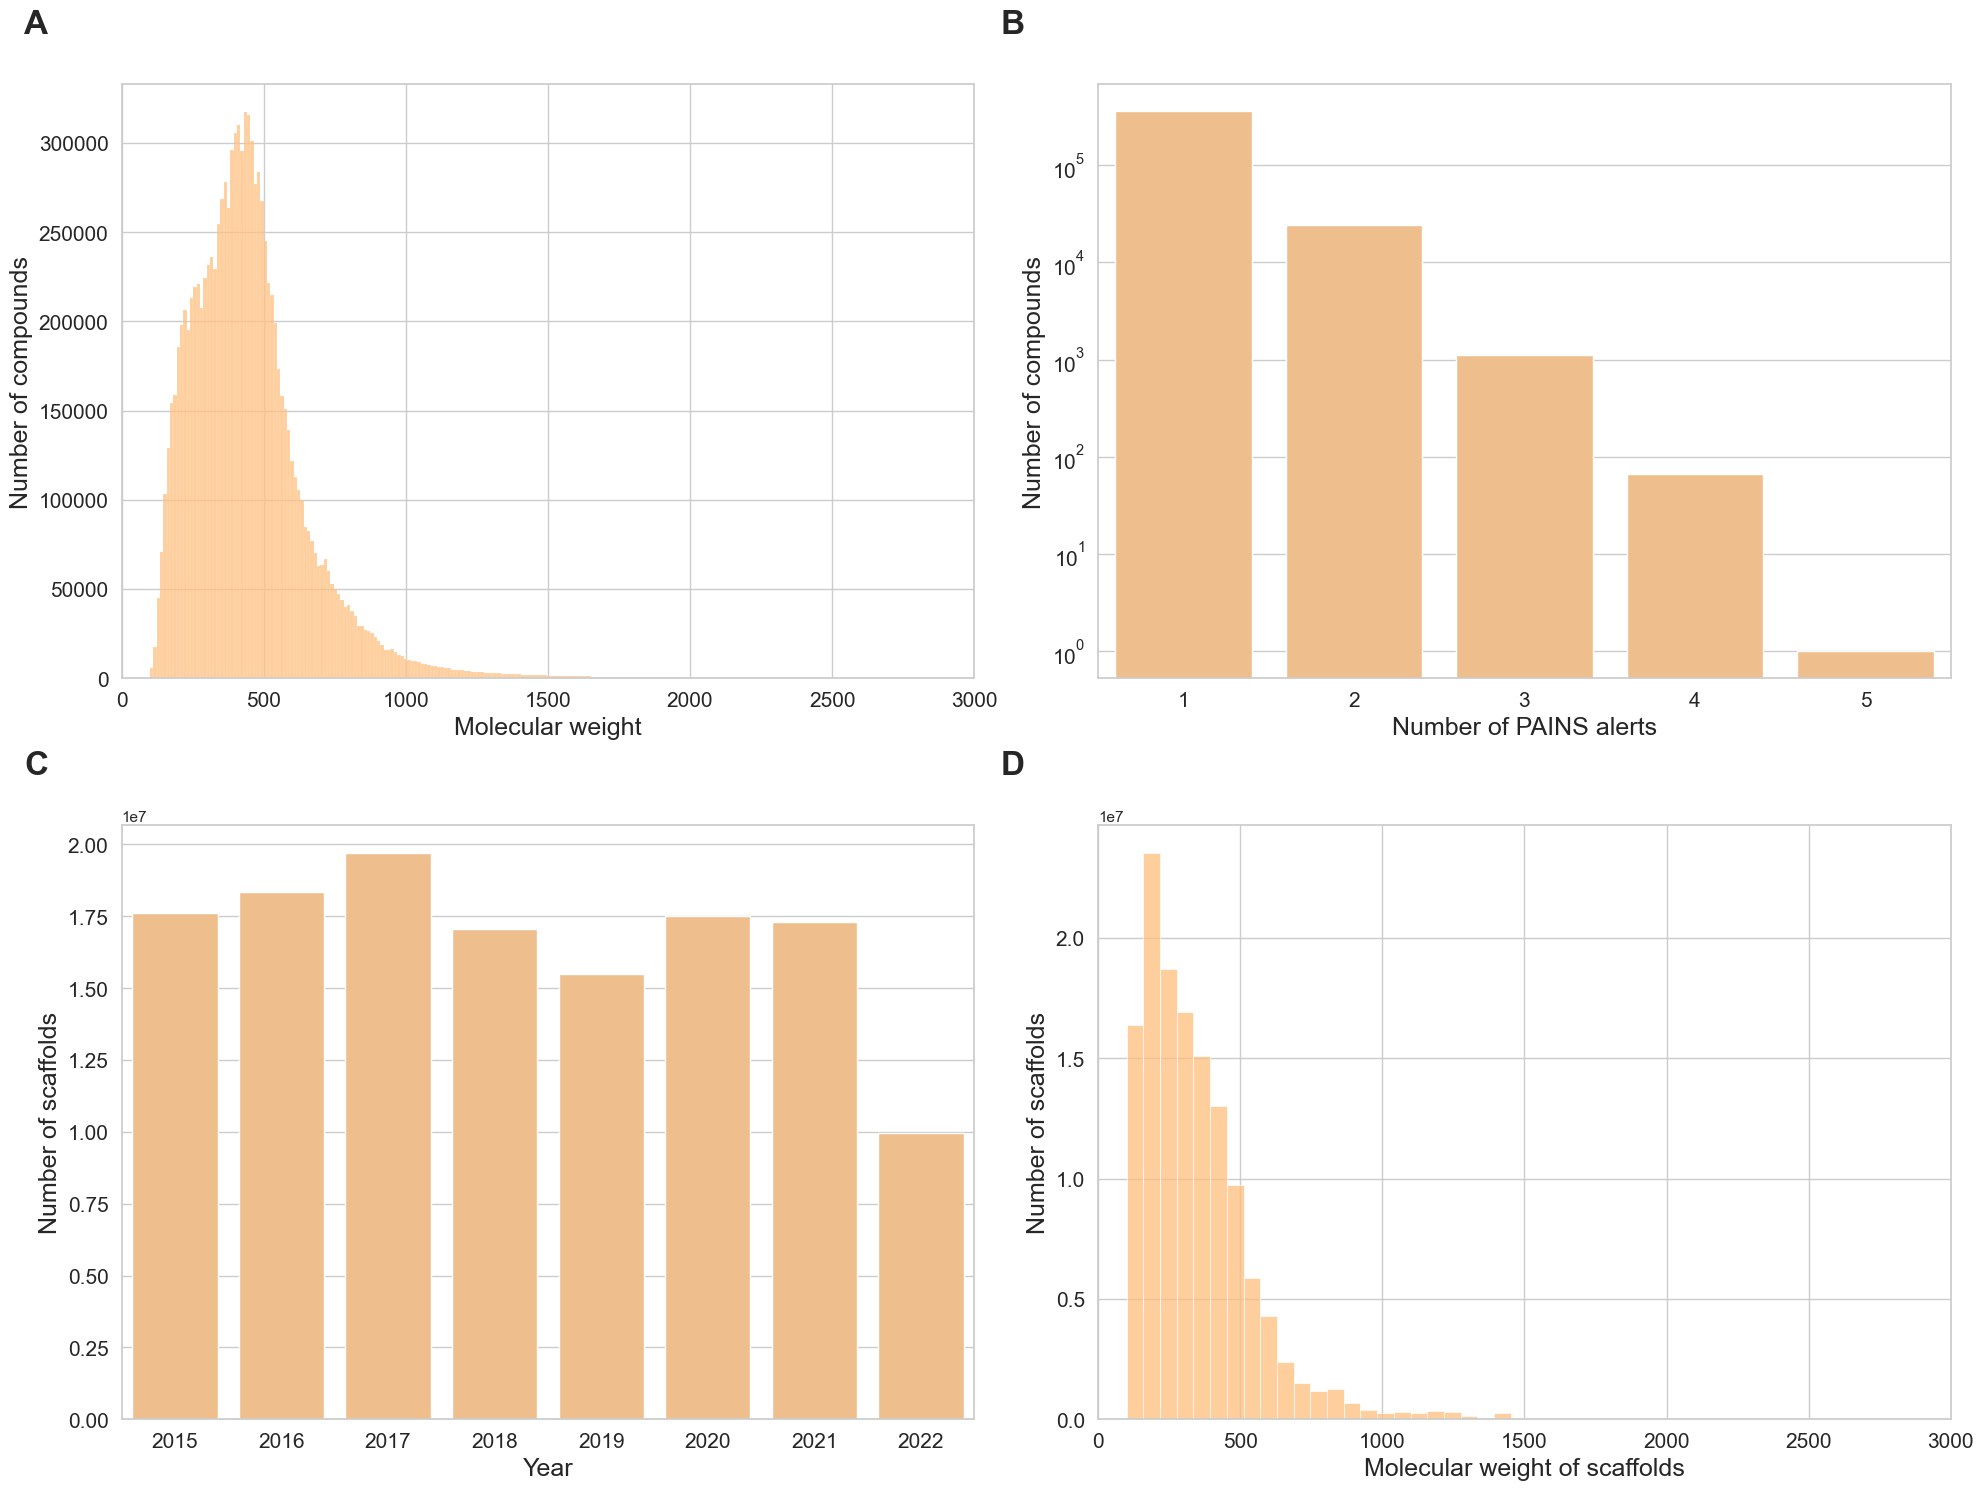

In [28]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.set_style("whitegrid")

# Molecular weight distribution
plt.subplot(2, 2, 1)
sns.histplot(x=mw_data, color='#ffbe7d', bins=500)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Molecular weight", fontsize=18)
plt.ylabel("Number of compounds", fontsize=18)
plt.xlim(0, 3000)
plt.text(
    -0.1, 1.1, string.ascii_uppercase[0],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

# PAINS distribution
plt.subplot(2, 2, 2)
sns.barplot(x= pain_distribution_df['pains'], y= pain_distribution_df['count'], color='#ffbe7d')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.ylabel("Number of compounds", fontsize=18)
plt.xlabel("Number of PAINS alerts", fontsize=18)
plt.text(
    -0.1, 1.1, string.ascii_uppercase[1],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

# Scaffold distribution
plt.subplot(2, 2, 3)
sns.barplot(x= scaffold_count_df['year'], y= scaffold_count_df['scaffold'], color='#ffbe7d')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Number of scaffolds", fontsize=18)
plt.text(
    -0.1, 1.1, string.ascii_uppercase[2],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

# Distribution of molecular weight of scaffolds
plt.subplot(2, 2, 4)
sns.histplot(x=surechembl_df['scaffold_wt'], color='#ffbe7d', bins=100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Molecular weight of scaffolds", fontsize=18)
plt.ylabel("Number of scaffolds", fontsize=18)
plt.xlim(0, 3000)
plt.text(
    -0.1, 1.1, string.ascii_uppercase[3],
    size=24, weight='bold', horizontalalignment='center',
    verticalalignment='center', transform = plt.gca().transAxes
)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/figure_5.png', dpi=400)
plt.show()